# Modeling Exercises - Time Series

In [1]:
import pandas as pd
import numpy as np

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#custom module
import prepare as p
import acquire_func as a

### Exercises
The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.


----- 
SaaS - security as a service

Amount - is dollar amount

subscription_type - is the subscription type the customer has
    
    - see if subscription type is always the same dollar amount

In [3]:
df = pd.read_csv('saas.csv')

In [4]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


- Looks like Month_invoiced is the date

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [7]:
df.Month_Invoiced.value_counts().head(10)

2014-01-31    20000
2014-02-28    19800
2014-03-31    19599
2014-04-30    19413
2014-05-31    19221
2014-06-30    19038
2014-07-31    18851
2014-08-31    18672
2014-09-30    18494
2014-10-31    18313
Name: Month_Invoiced, dtype: int64

- Need to aggregate based on month
- sum up amount
- need to check subscription type

In [16]:
df.groupby(by = ['Subscription_Type', 'Amount']).count()

,,Month_Invoiced,Customer_Id,Invoice_Id
Subscription_Type,Amount,,,
0.0,0.0,496410,496410,496410
1.0,5.0,178212,178212,178212
2.0,10.0,70706,70706,70706
3.0,15.0,26474,26474,26474
4.0,20.0,18656,18656,18656


- looks like each plan is costs the same 

Plan = Amount

0.0 = 0.0

1.0 = 5.0

2.0 = 10.0

3.0 = 15.0

4.0 = 20.0

In [23]:
# change Month_invoiced to datetime
df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced)

In [26]:
# reset index
df = df.set_index('Month_Invoiced')

In [45]:
# Resample on sum, select only the amount column and make sure it's a dataframe
df1 = df.resample('M').sum()['Amount'].to_frame()

In [46]:
df1.head()

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


<AxesSubplot:xlabel='Month_Invoiced'>

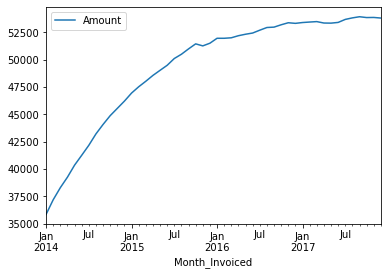

In [60]:
df1.plot()

<AxesSubplot:xlabel='Month_Invoiced'>

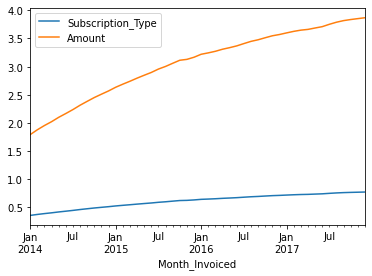

In [58]:
df.resample('M').mean()[['Subscription_Type', 'Amount']].plot()

### Takeaways
- Not sure what Kind of trend this is maybe a logarithmic
- Not sure where to split this data.
- I will do a manual with the last year as the test set


### Split
- Manual 
- Use the last year (2017) for test set

In [64]:
print(df1.index.min()) 
print(df1.index.max())

2014-01-31 00:00:00
2017-12-31 00:00:00


In [72]:
# set train to everything up through 2016 and test to everything in 2017
train = df1[:'2016']
test = df1.loc['2017']

### Helper Functions 

In [132]:
def evaluate(prediction):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(train['Amount'], yhat_df[prediction])), 0)
    return rmse

In [133]:
def plot_and_eval(prediction):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train['Amount'], label='Train', linewidth=1)
    plt.plot(test['Amount'], label='Test', linewidth=1)
    plt.plot(yhat_df[prediction])
    plt.title(prediction)
    rmse = evaluate(prediction)
    print(prediction, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [141]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, prediction, eval_df):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(prediction)
    d = {'model_type': [model_type],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [151]:
metric_df = pd.DataFrame(columns=['model_type', 'rmse'])
metric_df

,model_type,rmse


In [152]:
# simple Average

# assign mean to predictions dataframe
yhat_df = pd.DataFrame({'mean_pred': train['Amount'].mean()}, 
                      index = train.index)

Text(0.5, 1.0, 'Mean Prediction')

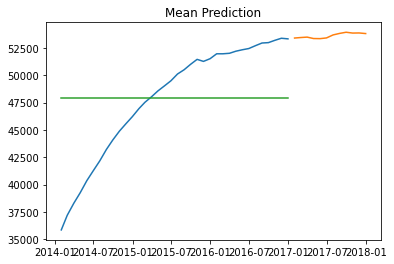

In [153]:
plt.plot(train['Amount'])
plt.plot(test['Amount'])
plt.plot(yhat_df['mean_pred'])
plt.title('Mean Prediction')

mean_pred -- RMSE: 5131


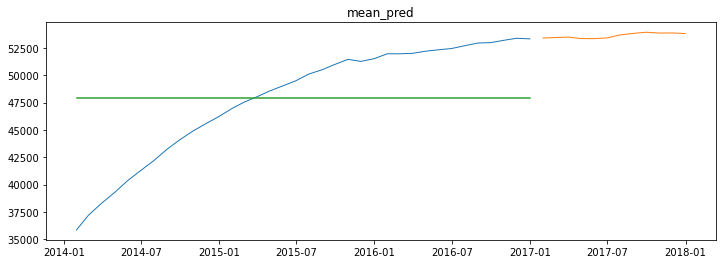

In [154]:
plot_and_eval('mean_pred')

In [155]:
metric_df = append_eval_df('Average','mean_pred', metric_df)

In [156]:
# moving Average
periods = [6, 12, 18, 24, 30, 36]

for p in periods: 
    prediction = round(train['Amount'].rolling(p).mean()[-1], 2)

    yhat_df = pd.DataFrame({'Model': prediction},
                             index= train.index)

    model_type = str(p) + 'd_moving_avg'
    
    metric_df = append_eval_df(model_type, 'Model', metric_df)

In [157]:
metric_df

,model_type,rmse
0,Average,5131.0
1,6d_moving_avg,7281.0
2,12d_moving_avg,6956.0
3,18d_moving_avg,6598.0
4,24d_moving_avg,6045.0
5,30d_moving_avg,5452.0
6,36d_moving_avg,5131.0


In [158]:
# holt's
import statsmodels.api as sm

In [162]:
col = 'Amount'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = train.index[0],
                           end = train.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

<ipython-input-162-fc13e0744a57>:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model = Holt(train[col], exponential=False, damped=True)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Amount -- RMSE: 224


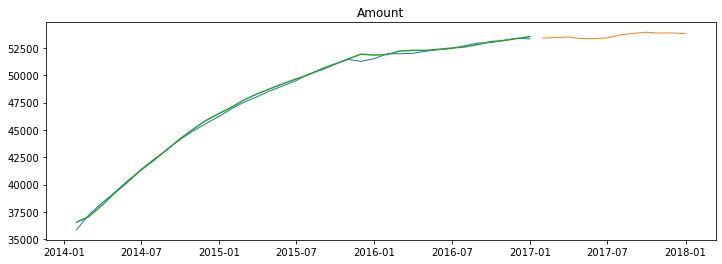

In [164]:
plot_and_eval('Amount')

### Takeaways
- Wasn't sure how to split this data into train validate and test
- So I'll need to revisit the function to make them work with just test
- Not finding a clear seasonal pattern in this data threw me off in this regard
- Will revisit to try and split in a different way. 

In [76]:
# based on last year